In [ ]:
### INITIALLY APPEARED IN data-cleanup 
# did the USA really not host any tournaments after 2013? 
USA_events = tournament_df[tournament_df['country']=="USA"]
post_2013_USA_events = USA_events[USA_events['season']>2013]
pre_2013_USA_events = USA_events[USA_events['season']<=2013]
# missing_tournaments = tournament_df[(tournament_df['missing_results_flag'].notna()) & (tournament_df['season'] > 2013)]
results_tournaments = tournament_df[(tournament_df['missing_results_flag'].isna()) & (tournament_df['season'] > 2013)]
post_2013_USA_events
results_tournaments_USA = USA_events[(USA_events['missing_results_flag'].isna()) & (USA_events['season'] > 2013)]
results_tournaments_USA
results_tournaments[results_tournaments['country']=="USA"]
test = results_tournaments.groupby('country').count()['competition_ID']
test


In [11]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit 
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12]])
y = np.array([0, 1, 2, 3, 4, 5])
print(X)
print(y)
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("Train Data:\n", "X - \n",X_train,"\nY - ", y_train)
    print("Test Data: \n", "X - \n",X_test, "\nY - ", y_test)
    
# okay so need to sort data by date first it seems... kind want to just extract all the dates and do a split by that? 


[[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]
 [11 12]]
[0 1 2 3 4 5]
TRAIN: [0 1] TEST: [2 3]
Train Data:
 X - 
 [[1 2]
 [3 4]] 
Y -  [0 1]
Test Data: 
 X - 
 [[5 6]
 [7 8]] 
Y -  [2 3]
TRAIN: [0 1 2 3] TEST: [4 5]
Train Data:
 X - 
 [[1 2]
 [3 4]
 [5 6]
 [7 8]] 
Y -  [0 1 2 3]
Test Data: 
 X - 
 [[ 9 10]
 [11 12]] 
Y -  [4 5]


In [12]:
import pandas as pd 
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# load dataframes from CSV files 
from data.load_csv import cleaned_tournament_df, cleaned_bout_df, cleaned_fencer_bio_df, cleaned_fencer_rankings_df

# copy dataframes for cleanup 
tournament_df, bout_df, fencer_bio_df, fencer_rankings_df = \
    cleaned_tournament_df.copy(), cleaned_bout_df.copy(), cleaned_fencer_bio_df.copy(), cleaned_fencer_rankings_df.copy()

In [13]:
tournament_df.shape

(218, 14)

In [16]:
bout_df.head()

,Unnamed: 0,fencer_ID,opp_ID,fencer_age,opp_age,fencer_score,opp_score,winner_ID,fencer_curr_pts,opp_curr_pts,tournament_ID,pool_ID,upset,date
0,0,36796,19574,23,28,5,1,36796,12.5,7.50,2021-121,1,False,2021-03-26
1,1,36796,42147,23,19,5,2,36796,12.5,0.75,2021-121,1,False,2021-03-26
2,2,36796,49116,23,21,5,2,36796,12.5,22.25,2021-121,1,True,2021-03-26
3,3,36796,39631,23,18,5,4,36796,12.5,23.00,2021-121,1,True,2021-03-26
4,4,36796,23447,23,27,4,5,23447,12.5,79.00,2021-121,1,False,2021-03-26


In [46]:

mini_bouts = bout_df.sample(20).drop(columns=["Unnamed: 0"])
mini_bouts.sort_values(by='tournament_ID')

,fencer_ID,opp_ID,fencer_age,opp_age,fencer_score,opp_score,winner_ID,fencer_curr_pts,opp_curr_pts,tournament_ID,pool_ID,upset,date
40504,27157,32578,26,25,3,5,32578,26.0,0.0,2015-122,13,True,2015-05-01
1793,9309,31645,34,23,5,1,9309,0.0,0.0,2015-1281,1,False,2015-05-10
27186,28701,32900,24,21,5,1,28701,0.0,0.0,2015-42,1,False,2015-01-10
24075,32904,40259,24,24,5,1,32904,0.0,0.0,2016-35,6,False,2016-02-13
46781,21091,39140,31,22,5,3,21091,85.0,2.5,2016-457,12,False,2016-06-03
2677,17406,39631,31,18,2,5,39631,1.0,4.0,2017-122,19,False,2017-04-28
44987,42181,12287,21,33,0,5,12287,0.0,19.5,2017-125,9,False,2016-10-14
40728,34971,32248,30,23,0,5,32248,0.0,3.0,2017-1281,1,False,2017-05-28
6858,31906,29054,25,24,2,5,29054,0.0,21.0,2017-129,11,False,2017-02-03
36087,40705,33825,20,20,3,5,33825,0.0,0.0,2017-237,4,False,2017-04-03


In [70]:
from sklearn.model_selection import TimeSeriesSplit 
X = mini_bouts.copy().sort_values(by='date')
X.drop(X.index[[0,1,2,3,4,5,6,7]],inplace=True)
print(X.shape)
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    print("Train Data:\n", "X - \n",X_train[['fencer_ID','opp_ID','tournament_ID','pool_ID','date']])
    print("Test Data: \n", "X - \n",X_test[['fencer_ID','opp_ID','tournament_ID','pool_ID','date']])
    

(12, 13)
TRAIN: [0 1 2] TEST: [3 4 5]
Train Data:
 X - 
        fencer_ID  opp_ID tournament_ID  pool_ID        date
36087      40705   33825      2017-237        4  2017-04-03
2677       17406   39631      2017-122       19  2017-04-28
39277      39244   20461      2017-457        9  2017-05-19
Test Data: 
 X - 
        fencer_ID  opp_ID tournament_ID  pool_ID        date
40728      34971   32248     2017-1281        1  2017-05-28
20739      39652   34549       2018-33       13  2017-10-07
18560      46180   39195      2018-771        2  2018-02-28
TRAIN: [0 1 2 3 4 5] TEST: [6 7 8]
Train Data:
 X - 
        fencer_ID  opp_ID tournament_ID  pool_ID        date
36087      40705   33825      2017-237        4  2017-04-03
2677       17406   39631      2017-122       19  2017-04-28
39277      39244   20461      2017-457        9  2017-05-19
40728      34971   32248     2017-1281        1  2017-05-28
20739      39652   34549       2018-33       13  2017-10-07
18560      46180   39195      

In [75]:
mini_bouts2 = bout_df[bout_df['tournament_ID'].isin(['2017-457','2017-457','2020-129'])]
mini_bouts2 = mini_bouts2.sample(20).drop(columns=['Unnamed: 0'])
mini_bouts2

,fencer_ID,opp_ID,fencer_age,opp_age,fencer_score,opp_score,winner_ID,fencer_curr_pts,opp_curr_pts,tournament_ID,pool_ID,upset,date
28781,37239,17872,21,28,3,5,17872,2.375,19.5,2020-129,13,False,2020-02-21
39361,43803,29323,22,29,0,5,29323,0.000,3.0,2017-457,13,False,2017-05-19
39189,15803,32965,29,21,1,5,32965,7.000,5.0,2017-457,4,True,2017-05-19
39257,24756,28086,28,24,3,5,28086,9.000,72.0,2017-457,8,False,2017-05-19
39163,17872,21767,28,24,5,4,17872,26.000,13.0,2017-457,3,False,2017-05-19
39132,29115,34704,25,24,1,2,34704,68.500,9.0,2017-457,2,True,2017-05-19
39356,12591,37737,31,21,5,0,12591,32.000,1.0,2017-457,12,False,2017-05-19
39450,4437,35663,38,22,5,1,4437,42.000,1.0,2017-457,17,False,2017-05-19
28576,36454,37569,21,22,5,0,36454,0.500,0.0,2020-129,3,False,2020-02-21
28583,26919,22533,27,27,0,5,22533,8.250,28.0,2020-129,4,False,2020-02-21


In [80]:
from sklearn.model_selection import TimeSeriesSplit 
X = mini_bouts2.copy().sort_values(by='date')
# X.drop(X.index[[0,1,2,3,4,5,6,7]],inplace=True)
print(X.shape)
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    print("Train Data:\n", "X - \n",X_train[['fencer_ID','opp_ID','tournament_ID','pool_ID','date']])
    print("Test Data: \n", "X - \n",X_test[['fencer_ID','opp_ID','tournament_ID','pool_ID','date']])
    

(20, 13)
TRAIN: [0 1 2 3 4] TEST: [5 6 7 8 9]
Train Data:
 X - 
        fencer_ID  opp_ID tournament_ID  pool_ID        date
39361      43803   29323      2017-457       13  2017-05-19
39189      15803   32965      2017-457        4  2017-05-19
39257      24756   28086      2017-457        8  2017-05-19
39163      17872   21767      2017-457        3  2017-05-19
39132      29115   34704      2017-457        2  2017-05-19
Test Data: 
 X - 
        fencer_ID  opp_ID tournament_ID  pool_ID        date
39356      12591   37737      2017-457       12  2017-05-19
39450       4437   35663      2017-457       17  2017-05-19
39451       4437   28365      2017-457       17  2017-05-19
39152      18557   27015      2017-457        3  2017-05-19
39437      12156    8280      2017-457       16  2017-05-19
TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10 11 12 13 14]
Train Data:
 X - 
        fencer_ID  opp_ID tournament_ID  pool_ID        date
39361      43803   29323      2017-457       13  2017-05-19
39189

In [90]:
from datetime import datetime
date = pd.to_datetime('2021-01-01')
print(date)
bouts_before = bout_df[pd.to_datetime(bout_df['date'])<date]


2021-01-01 00:00:00


In [91]:
bouts_before.sort_values(by='date')

,Unnamed: 0,fencer_ID,opp_ID,fencer_age,opp_age,fencer_score,opp_score,winner_ID,fencer_curr_pts,opp_curr_pts,tournament_ID,pool_ID,upset,date
36702,36708,35072,30262,23,23,0,5,30262,0.00,0.00,2014-237,3,False,2014-04-03
36816,36822,34747,32608,22,21,1,5,32608,0.00,0.00,2014-237,8,False,2014-04-03
36815,36821,34827,35056,22,24,5,2,34827,0.00,0.00,2014-237,8,False,2014-04-03
36814,36820,34827,30327,22,23,2,5,30327,0.00,0.00,2014-237,8,False,2014-04-03
36813,36819,34827,34564,22,22,3,5,34564,0.00,0.00,2014-237,8,False,2014-04-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10192,10198,43551,49641,19,16,5,0,43551,0.75,0.00,2020-771,6,False,2020-03-01
10193,10199,43551,33609,19,22,3,5,33609,0.75,3.00,2020-771,6,False,2020-03-01
10194,10200,43551,39652,19,19,4,5,39652,0.75,0.00,2020-771,6,True,2020-03-01
10186,10192,48877,43551,19,19,0,5,43551,0.00,0.75,2020-771,6,False,2020-03-01


In [96]:
import datetime
def get_bouts_before_date(date):
    bouts_before = bout_df[pd.to_datetime(bout_df['date'])<date]
    return bouts_before.shape[0], bouts_before.shape[0]/bout_df.shape[0]
count, perc = get_bouts_before_date(pd.to_datetime('2020-01-01'))
print("{}, {:.2%}".format(count, perc))


44700, 90.98%


In [110]:
months = pd.date_range(start='1/1/2014',  end='6/1/2021', freq='M')
months

DatetimeIndex(['2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
      

In [105]:
len(months)
test = [0]*len(months)
test[0]=1
test

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [111]:
counts   = [0]*len(months)
percents = [0]*len(months)
for idx, date in enumerate(months):
    counts[idx], percents[idx] = get_bouts_before_date(date)
#     print("Count: {:<5}   Percentage: {:.2%}".format(count, perc))

In [118]:
percents

[0.0,
 0.0,
 0.0,
 0.005190205776393723,
 0.005190205776393723,
 0.005190205776393723,
 0.005190205776393723,
 0.005190205776393723,
 0.008976002930939732,
 0.017219270928741526,
 0.04982597545337974,
 0.057641814740184406,
 0.07089210478109544,
 0.083959211088722,
 0.09959088966233132,
 0.11107040361482567,
 0.13079318556512182,
 0.13816124239278663,
 0.14341250941360853,
 0.14341250941360853,
 0.15047526001913253,
 0.1652520811707476,
 0.20256050151635424,
 0.2103763408031589,
 0.23309112373043495,
 0.2514094970588834,
 0.26183061610795627,
 0.2810852618509699,
 0.2902444485151941,
 0.3016018399788321,
 0.3016018399788321,
 0.3016018399788321,
 0.31137163908733795,
 0.33591825934745884,
 0.34556593596710833,
 0.361319737029574,
 0.37996377032830597,
 0.3944963465022084,
 0.41312002605279763,
 0.434064032891657,
 0.4444444444444444,
 0.4521381612423928,
 0.4565956320856486,
 0.46025930675133825,
 0.46532739003887563,
 0.4943518348903951,
 0.5102888196861453,
 0.524210783415766,
 0.551

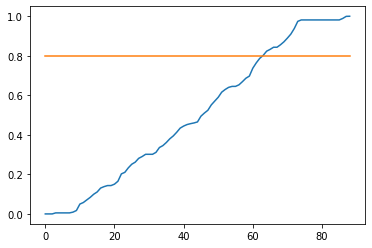

In [117]:
import matplotlib.pyplot as plt 
plt.plot(percents)
plt.plot([0.8]*len(months))


Based on points at the time of event, predicting the higher points to win (and 50-50 for unranked) probably has an expected accuracy of 82% (the 50-50 may be off, so could be worse than that).